# Задача классификации. kNN


Перед тем, как строить модели, хорошо бы понять, а как мы будем измерять качество их работы? 

Мы с вами будем работать с задачей бинарной классификации, то есть возможных вариантов целевой переменной может быть всего 2. Для наглядности предположим, что предсказываем беременность. 

В этом случае у нашего алгоритма может быть 4 варианта развития событий - предсказать беременность, когда она действительно есть, предсказать её отсутствие, когда её действительно нет, или совершить один из двух типов ошибок:

![](http://blog.exsilio.com/wp-content/uploads/2016/09/table-blog.png)

* Ошибка первого рода: мы предсказали человеку, что он беременен, а по факту нет.
* Ошибка второго рода: мы предсказали, что человек не беременен, а по факту - да.


![](https://miro.medium.com/max/3200/1*fSOPZZt8Bbm-lzNQhfqRLw.jpeg)



В разных задачах критичны разные виды ошибок. На основе этих ошибок можно придумать много метрик. 


### 1) Доля верно классифицированных объектов (Accuracy):

Берем всё, что предсказали правильно, делим на число всех наблюдений

$$Accuracy = \frac{TP + TN}{TP + FP + TN + FN}$$

Интуитивно понятная, очевидная и почти неиспользуемая метрика. Её главная проблема в том, что она бесполезна в задачах с неравными классами. Например, пусть у нас есть $50$ больных и $950$ здоровых. Мы хотим научиться их различать. Пусть наш алгоритм предсказывает, что все здоровы. В этом случае доля правильных ответов составит $95\%$, но алгорим окажется абсолютно бесполезным. 

Чтобы избежать таких эксцессов, а также учитывать, что разные типы ошибок могут иметь разную цену, строят другие две метрики: точность и полноту. 

### 2) Точность (Precision): 

$$P = \frac{TP}{TP + FP}$$

Отражает то, насколько мы можем доверять алгоритму, если он спрогнозировал единичку. 

### 3) Полнота (Recall): 

$$R = \frac{TP}{TP + FN}$$

Показывает, как много объектов первого класса наш алгоритм находит.

Введение precision не позволяет нам записывать все объекты в один класс, так как в этом случае мы получаем рост уровня False Positive. Recall демонстрирует способность алгоритма обнаруживать данный класс вообще, а precision — способность отличать этот класс от других классов.

Давайте составим для алгоритма из первого пункта матрицу ошибок и подсчитаем эти две метркии. Под классом $1$ будем понимать больных. Именно их мы хотели бы найти.  


|          | $y=1$ | $y=0$ |
|----------|-------|-------|
|$a(x) = 1$|  0    |  0    | 
|$a(x) = 0$|  50   |  950  | 


Точность будет равна нулю. Полнота тоже. Мы видим насколько алгоритм никчёмен. 

Более высокая точность влечёт более низкую полноту. Баланс между этими характеристиками выбирается в зависимости от задачи. В случае поиска больных, нам бы хотелось получить максимальную полноту. Не страшно, если здоровый сдаст анализы, страшно если мы пропустим больного. В задаче выдаче кредитов, наоборот, важнее точность.

Можно склеить эти две метрики, посчитав их среднее гармонческое и получить f-меру: 

### 4) F-measure: 

$$F = \frac{1}{\beta\frac{1}{P} + (1 - \beta)\frac{1}{R}}$$

Параметр $\beta$ в данном случае определяет вес точности в метрике. $\beta = 1$ вносит точность и полноту с одинаковыми весами. Изменяя его, можно отдавать предпочтения либо одному либо другому. 

Все эти метрики, конечно же, уже есть в пакете sklearn. 

```python
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
```

# Classification task. k-nearest neighbors method (kNN)

In [2]:
import pandas as pd
import numpy as np
from sklearn import datasets
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt


%matplotlib inline
#plt.rcParams["figure.figsize"] = [8, 8]

import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)

## KNN in classification task

In [3]:
X, y = datasets.make_blobs(n_samples=100, random_state=4, centers=2, cluster_std=2)
X[:5], y[:5]

(array([[13.78731721,  1.73323541],
        [10.68075246,  3.87600675],
        [ 8.09139034,  0.36429043],
        [10.80129018,  6.34922981],
        [ 8.78819007,  2.53766878]]),
 array([0, 1, 1, 1, 0]))

In [4]:
def get_class_colour(class_label):
    return 'green' if class_label else 'blue'

In [5]:
def plot_points(X, y, new_points=None, new_prediction=None, nearest_points=None, file_name=None):
    plt.figure(figsize=(8, 8))
    plt.scatter(X[:, 0], X[:, 1], c=[get_class_colour(y_i) for y_i in y], s=100, edgecolor='black', alpha=0.3)
    
    if new_points is not None:
        plt.scatter(new_points[:, 0], new_points[:, 1], c='black', s=100, edgecolor='black')
    
    if new_prediction is not None:
        plt.scatter(new_points[:, 0], new_points[:, 1], c=[get_class_colour(y_i) for y_i in new_prediction], s=100, edgecolor='black')
        
    if nearest_points is not None:
        plt.scatter(nearest_points[:, 0], nearest_points[:, 1], c='red', s=100, edgecolor='black')
    
    plt.title("Classification problem \n What is the color for the new (x1, x2) pair?")
    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    
    if file_name:
        plt.savefig(filename)

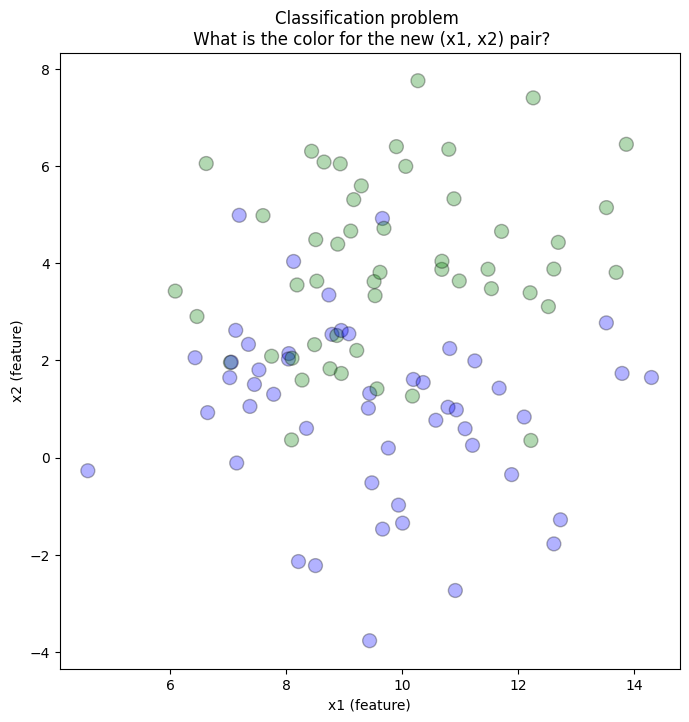

In [6]:
plot_points(X, y)

In [7]:
X_new = np.array([[12, 6]])

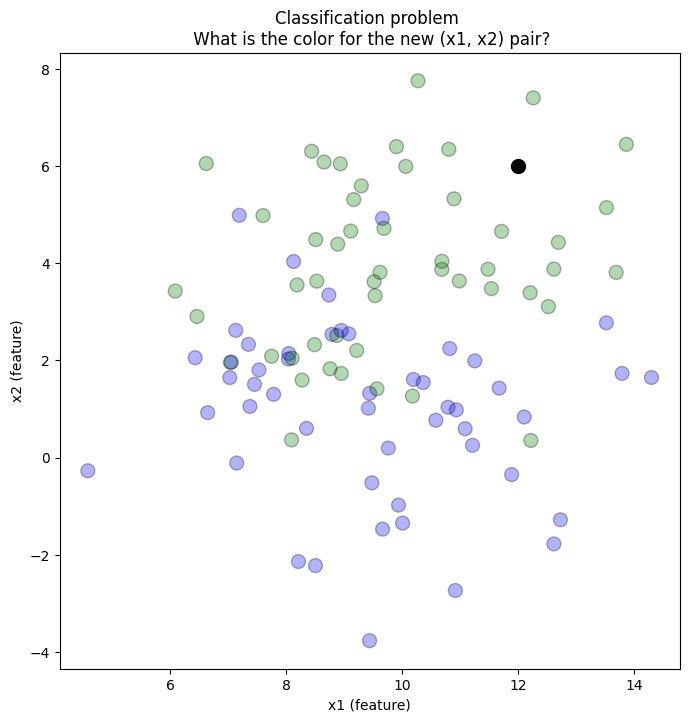

In [8]:
plot_points(X, y, new_points=X_new)

In [12]:
# nearest point
from scipy.spatial.distance import euclidean

def find_nearest_point_index(x_new, X):
    d_min = euclidean(x_new[0], X[0])
    min_idx = 0
    for idx in range(1, X.shape[0]):
        d = euclidean(x_new[0], X[idx])
        if d < d_min:
            d_min = d
            min_idx = idx
    return min_idx


min_idx = find_nearest_point_index(X_new, X)

[[12  6]] [13.78731721  1.73323541]


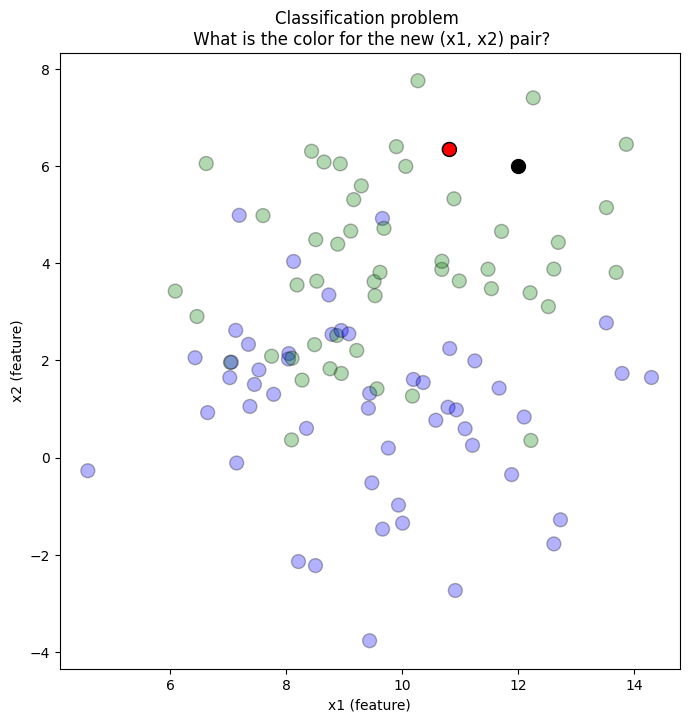

In [13]:
plot_points(X, y, new_points=X_new, nearest_points=X[[min_idx]])

In [14]:
def predict_class(x_new, X, y):
    min_idx = find_nearest_point_index(x_new, X)
    return y[min_idx]

y_new = predict_class(X_new, X, y)

[[12  6]] [13.78731721  1.73323541]


In [15]:
y_new

1

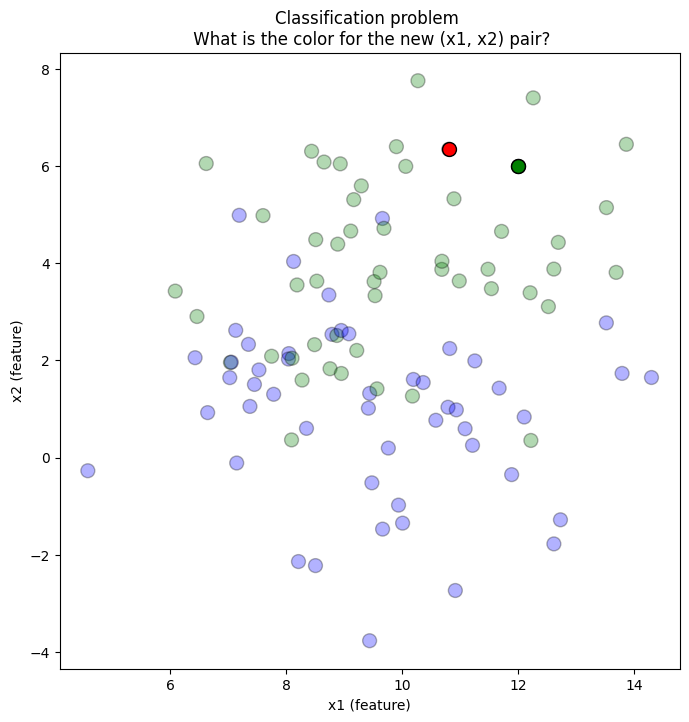

In [16]:
plot_points(X, y, new_points=X_new, new_prediction=[y_new], nearest_points=X[[min_idx]])

In [17]:
X_new = np.array([[12, -2]])
min_idx = find_nearest_point_index(X_new, X)
y_new = predict_class(X_new, X, y)

[[12 -2]] [13.78731721  1.73323541]
[[12 -2]] [13.78731721  1.73323541]


In [18]:
y_new

0

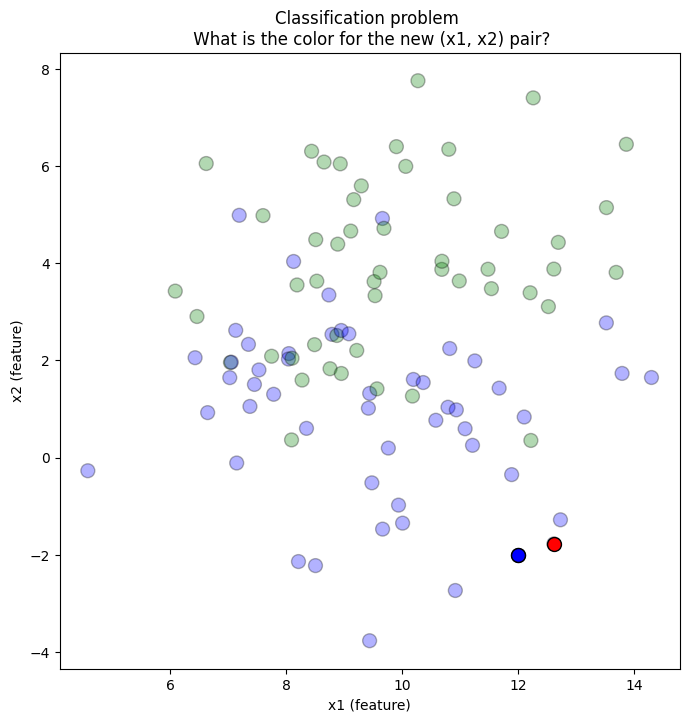

In [19]:
plot_points(X, y, new_points=X_new, new_prediction=[y_new], nearest_points=X[[min_idx]])

* k = 3

In [20]:
from scipy.spatial.distance import cdist
from collections import Counter

In [21]:
def predict_class(x_new, X, y, k=1):
    # cdist calculates pairwise distances between objects
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html
    dist = cdist(x_new, X)
    
    # argpartition finds sorted indices 
    # https://docs.scipy.org/doc/numpy/reference/generated/numpy.argpartition.html
    nearest_y = y[np.argpartition(dist, k, axis=1)[:, :k]]
    return np.array([Counter(row).most_common(1)[0][0] for row in nearest_y])

In [22]:
X_new

array([[12, -2]])

In [23]:
y_pred = predict_class(X_new, X, y, k=3)

In [24]:
y_pred

array([0])

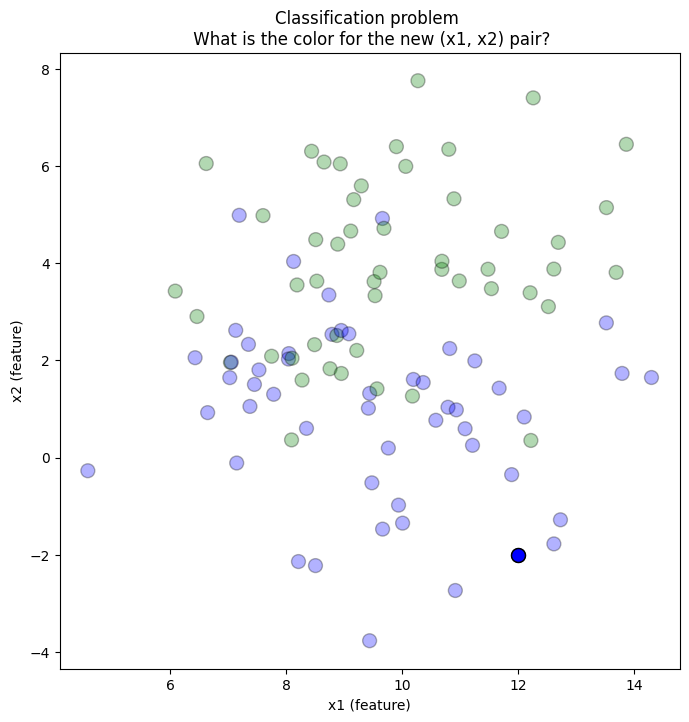

In [25]:
plot_points(X, y, new_points=X_new, new_prediction=y_pred)

## Sklearn

In [26]:
from sklearn.neighbors import KNeighborsClassifier

In [27]:
knn = KNeighborsClassifier(n_neighbors=1)
knn

KNeighborsClassifier(n_neighbors=1)

In [28]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X, y)
y_pred = knn.predict(X_new)

In [29]:
y_pred

array([0])

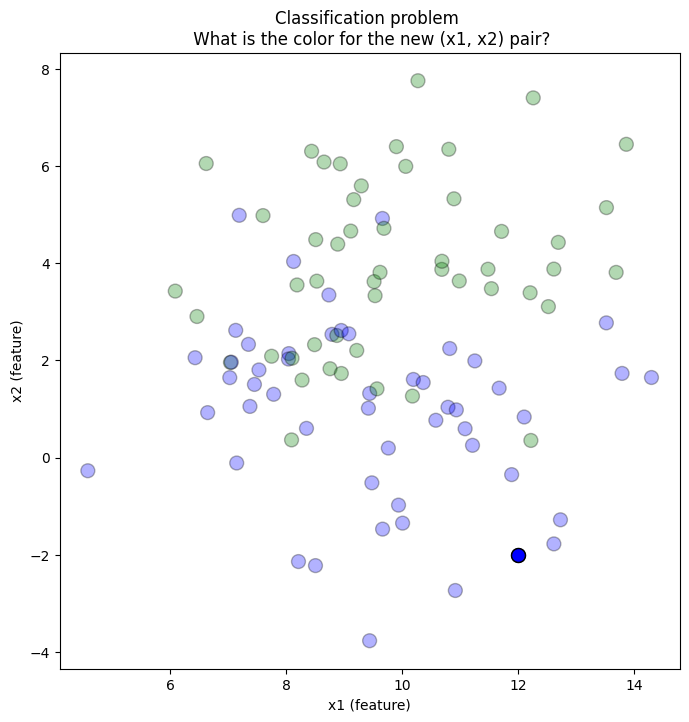

In [30]:
plot_points(X, y, new_points=X_new, new_prediction=[y_pred])

In [31]:
X_new = np.c_[np.random.randint(5, 15, 10), np.random.randint(-2, 8, 10)]

In [32]:
X_new

array([[14,  6],
       [ 9,  4],
       [ 5,  2],
       [ 6,  1],
       [14, -2],
       [ 5,  2],
       [ 6,  4],
       [13,  6],
       [14, -1],
       [ 5,  6]])

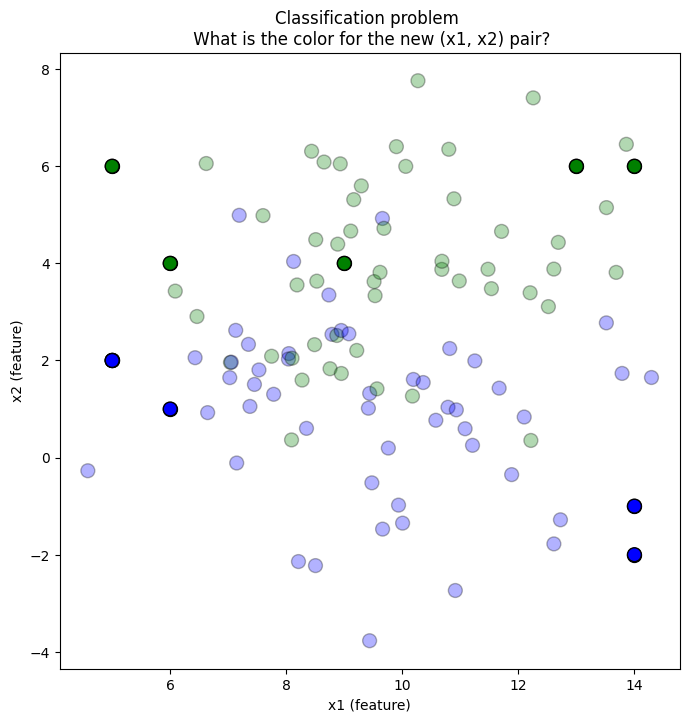

In [33]:
plot_points(X, y, new_points=X_new, new_prediction=knn.predict(X_new))

* k = 3

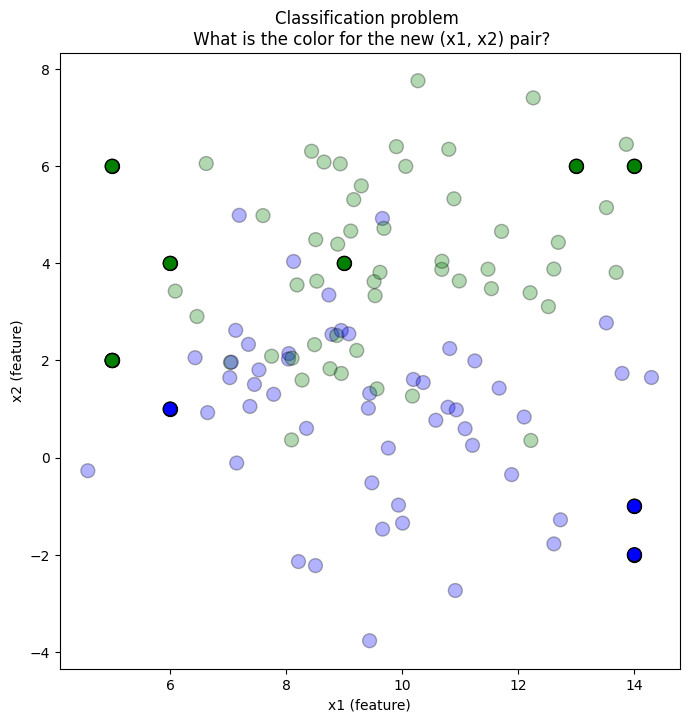

In [34]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X, y)
y_pred = knn.predict(X_new)
plot_points(X, y, new_points=X_new, new_prediction=y_pred)

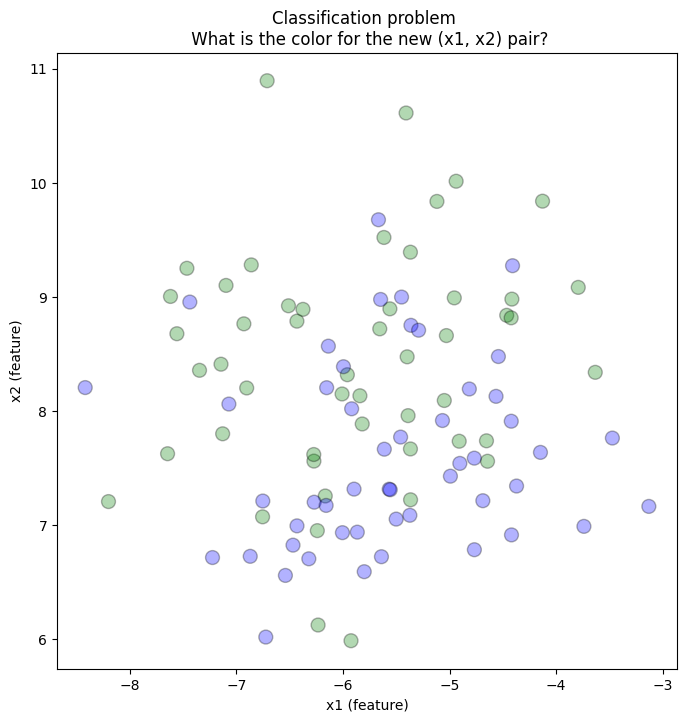

In [35]:
X, y = datasets.make_blobs(n_samples=100, random_state=5, centers=2)
plot_points(X, y)

# Influence of the number of neighbours - k

In [36]:
h = .02
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
x_pred = np.c_[xx.ravel(), yy.ravel()]

In [37]:
X.shape

(100, 2)

In [38]:
x_pred.shape

(93240, 2)

In [39]:
def plot_knn_classifier(k):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X, y)
    Z = knn.predict(x_pred)
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(12, 8))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

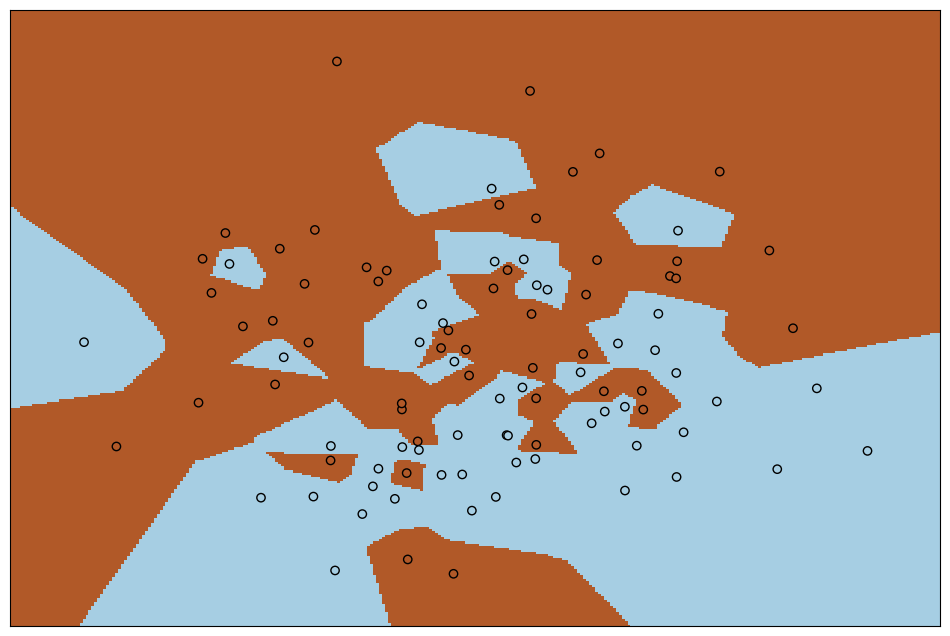

In [40]:
plot_knn_classifier(1)

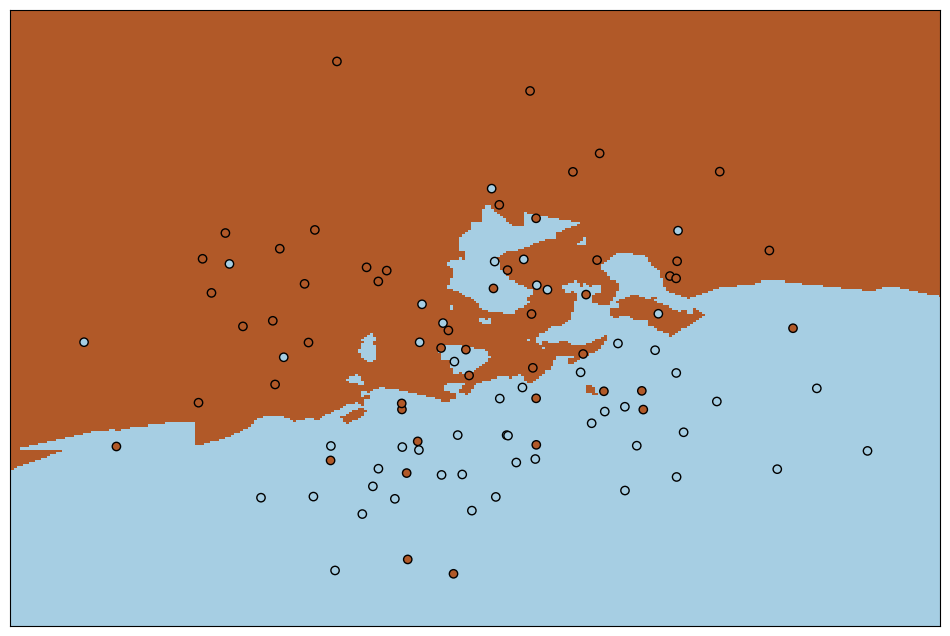

In [41]:
plot_knn_classifier(10)

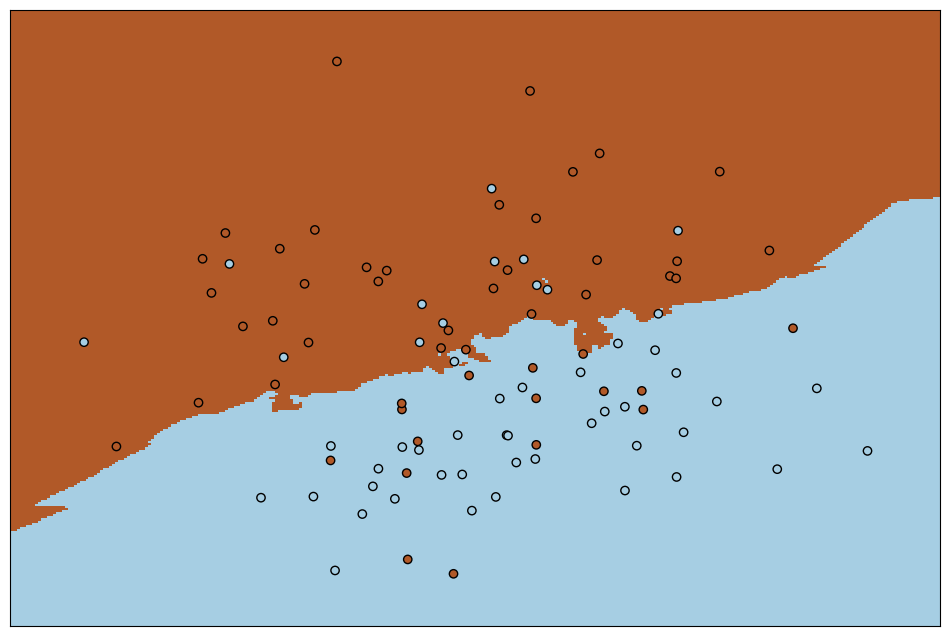

In [44]:
plot_knn_classifier(30)

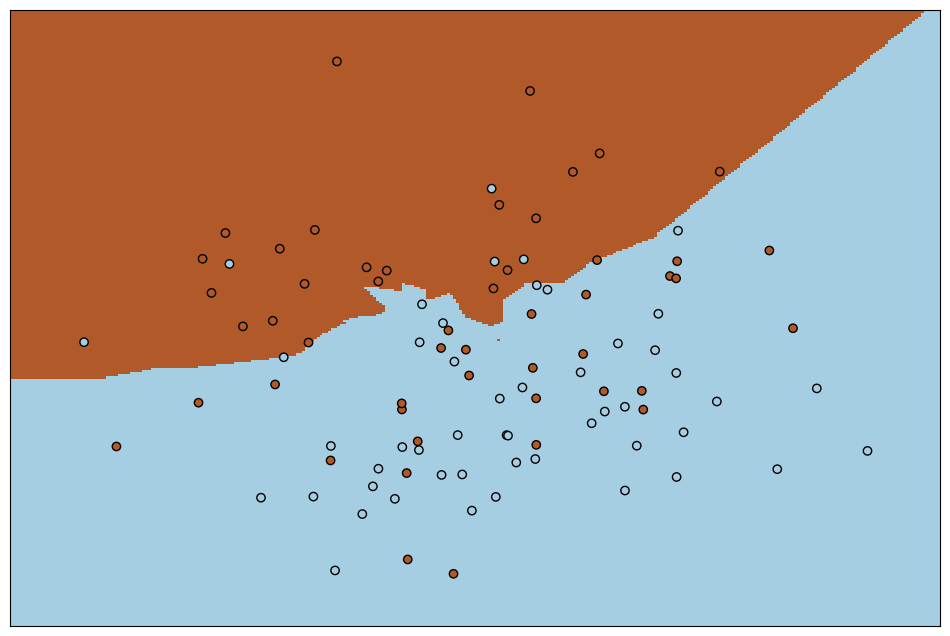

In [43]:
plot_knn_classifier(90)

Coming back to slides...

# Data normalization in knn

In [45]:
X, y = datasets.make_blobs(n_samples=100, random_state=4, centers=2, cluster_std=2)
X[:, 1] *= 1000000000
X[:5], y[:5]

(array([[1.37873172e+01, 1.73323541e+09],
        [1.06807525e+01, 3.87600675e+09],
        [8.09139034e+00, 3.64290431e+08],
        [1.08012902e+01, 6.34922981e+09],
        [8.78819007e+00, 2.53766878e+09]]),
 array([0, 1, 1, 1, 0]))

In [46]:
def plot_points_scaled(X, y, new_points=None, new_prediction=None, nearest_points=None, file_name=None):
    plt.scatter(X[:, 0], X[:, 1], c=[get_class_colour(y_i) for y_i in y], s=100, edgecolor='black', alpha=0.3)
    plt.figure(1, figsize=(12, 8))
    plt.title("Classification problem \n What is the color for the new (x1, x2) pair?")
    plt.xlabel("x1 (feature)")
    plt.ylabel("x2 (feature)")
    plt.gca().set_aspect('equal', adjustable='datalim')
    if file_name:
        plt.savefig(filename)

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [48]:
def quality(prediction_y, true_y):
    accuracy = accuracy_score(prediction_y, true_y)
    precision = precision_score(prediction_y, true_y)
    recall = recall_score(prediction_y, true_y)
    f1 = f1_score(prediction_y, true_y)
    print("Accuracy:  {:.3f}\nPrecision: {:.3f}\nRecall:    {:.3f}\nF1-score:  {:.3f}".format(
        accuracy, precision, recall, f1
    ))

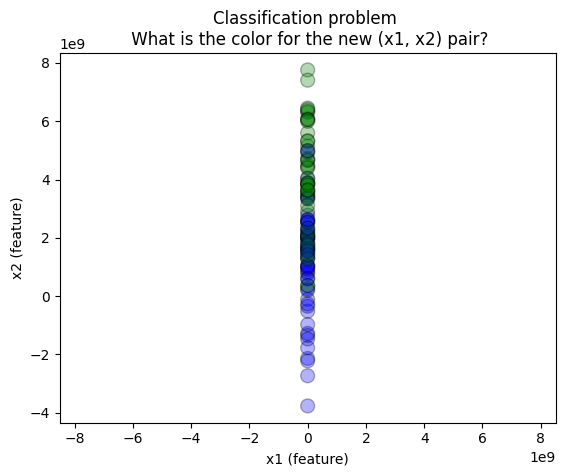

In [49]:
plot_points_scaled(X, y)

In [50]:
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X, y)
y_pred = knn.predict(X)
quality(y_pred, y)

Accuracy:  0.810
Precision: 0.760
Recall:    0.844
F1-score:  0.800


In [51]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

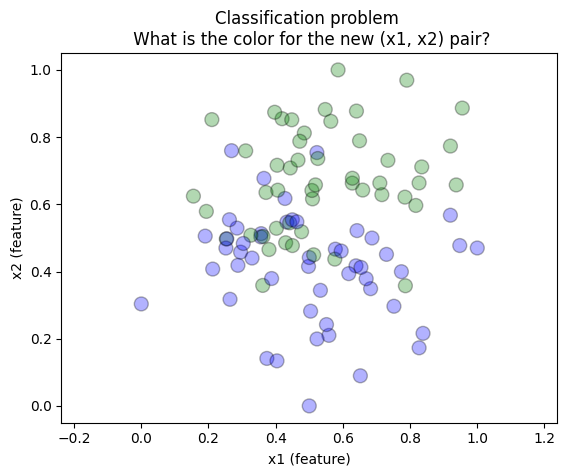

In [53]:
plot_points_scaled(X_scaled, y)

In [54]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_scaled, y)
y_pred = knn.predict(X_scaled)
quality(y_pred, y)

Accuracy:  0.870
Precision: 0.860
Recall:    0.878
F1-score:  0.869


# Choosing parameters of the model

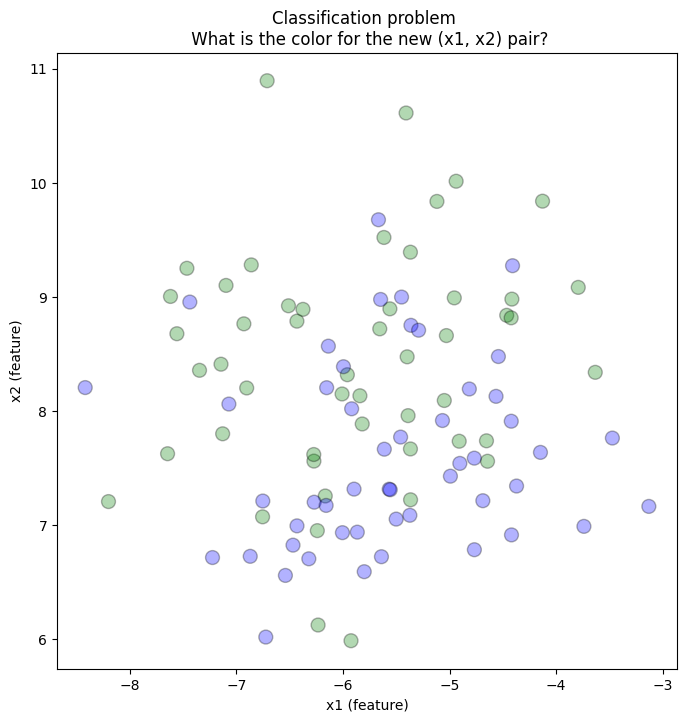

In [55]:
X, y = datasets.make_blobs(n_samples=100, random_state=5, centers=2)
plot_points(X, y)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [57]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((60, 2), (40, 2), (60,), (40,))

In [58]:
neighbors = range(1, 50)
neighbors

range(1, 50)

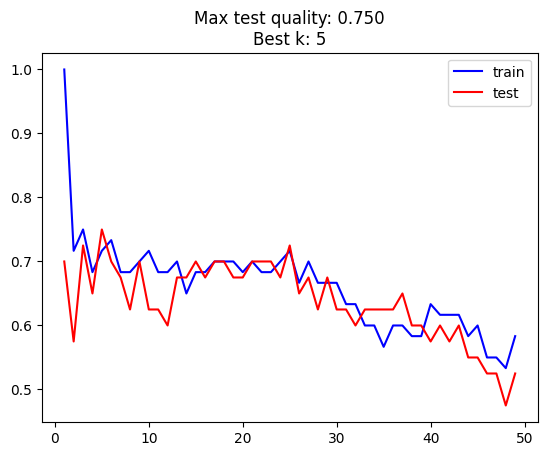

In [59]:
neighbors = range(1, 50)
accuracy_train = []
accuracy_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    preds = knn.predict(X_train)
    preds_test = knn.predict(X_test)
    accuracy_train.append(accuracy_score(preds, y_train))
    accuracy_test.append(accuracy_score(preds_test, y_test))
    
plt.plot(neighbors, accuracy_train, color='blue', label='train')
plt.plot(neighbors, accuracy_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(accuracy_test), np.argmax(accuracy_test)+1))
plt.legend()
plt.show()

((300, 2), (200, 2), (300,), (200,))

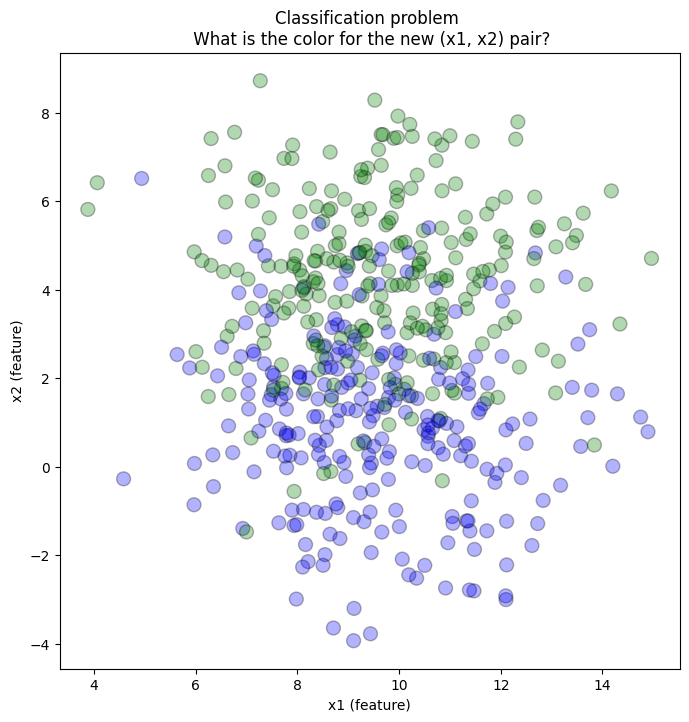

In [60]:
X, y = datasets.make_blobs(n_samples=500, random_state=4, centers=2, cluster_std=2)
plot_points(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

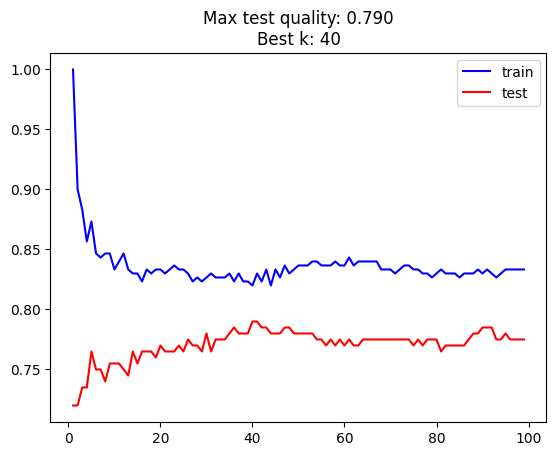

In [61]:
from sklearn.metrics import accuracy_score

neighbors = range(1, 100)
accuracy_train = []
accuracy_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracy_train.append(accuracy_score(knn.predict(X_train), y_train))
    accuracy_test.append(accuracy_score(knn.predict(X_test), y_test))
    
plt.plot(neighbors, accuracy_train, color='blue', label='train')
plt.plot(neighbors, accuracy_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(accuracy_test), np.argmax(accuracy_test)+1))
plt.legend()
plt.show()

## Кросс-валидация (k-fold cross-validation)

In [62]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=3)

scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
print(scores)
print('mean', scores.mean())
print('std', scores.std())

[0.8  0.78 0.8  0.77 0.72]
mean 0.774
std 0.029393876913398165


# Bonus: Hands-on modelling

https://www.kaggle.com/uciml/biomechanical-features-of-orthopedic-patients#_=_

Prediction of orthopedic problems from measurements of the pelvis and lower spine. Let's quickly go through the main stages of working with data.

Loading - Statistics and Visualization - Preprocessing - Modeling

In [64]:
data = pd.read_csv('data/data.csv')

In [65]:
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Abnormal
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Abnormal
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Abnormal
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Abnormal
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Abnormal


In [66]:
data.describe()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.000000,310.000000,310.000000,310.000000,310.000000,310.000000
mean,60.496653,17.542822,51.930930,42.953831,117.920655,26.296694
std,17.236520,10.008330,18.554064,13.423102,13.317377,37.559027
min,26.147921,-6.554948,14.000000,13.366931,70.082575,-11.058179
25%,46.430294,10.667069,37.000000,33.347122,110.709196,1.603727
50%,58.691038,16.357689,49.562398,42.404912,118.268178,11.767934
75%,72.877696,22.120395,63.000000,52.695888,125.467674,41.287352
max,129.834041,49.431864,125.742385,121.429566,163.071041,418.543082


In [67]:
data.isnull().sum()

pelvic_incidence            0
pelvic_tilt numeric         0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
class                       0
dtype: int64

## Target variable distribution

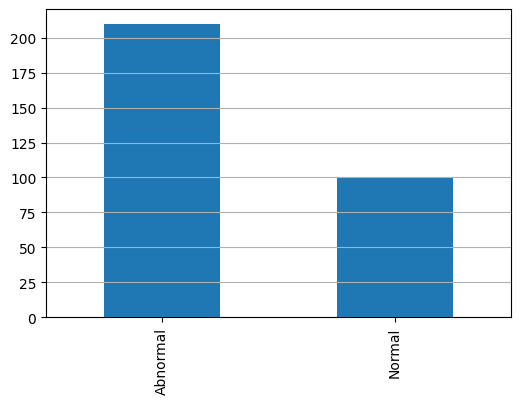

In [68]:
data['class'].value_counts().plot.bar(figsize=(6, 4))
plt.grid(axis='y')

In [69]:
data['class'].value_counts(normalize=True)

Abnormal    0.677419
Normal      0.322581
Name: class, dtype: float64

Here you can also estimate our **baseline** qualities, with which it will be possible to compare the results of the model. If we have 68% of one class and 32% of another, then even if our model predicts solid `Abnormal`, then `accuracy` will be equal, on average, to 68%.

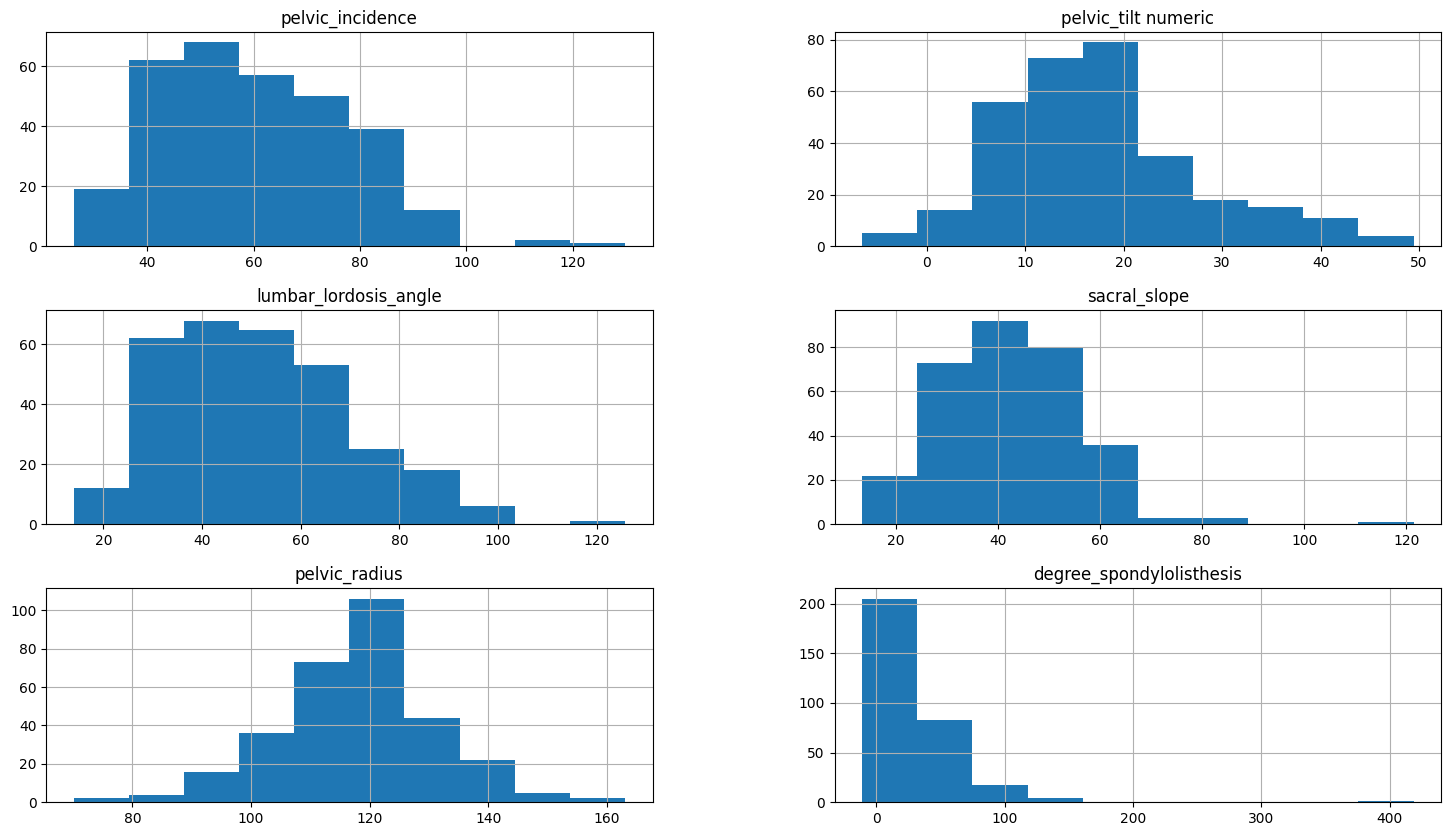

In [70]:
data.hist(figsize=(18, 10));

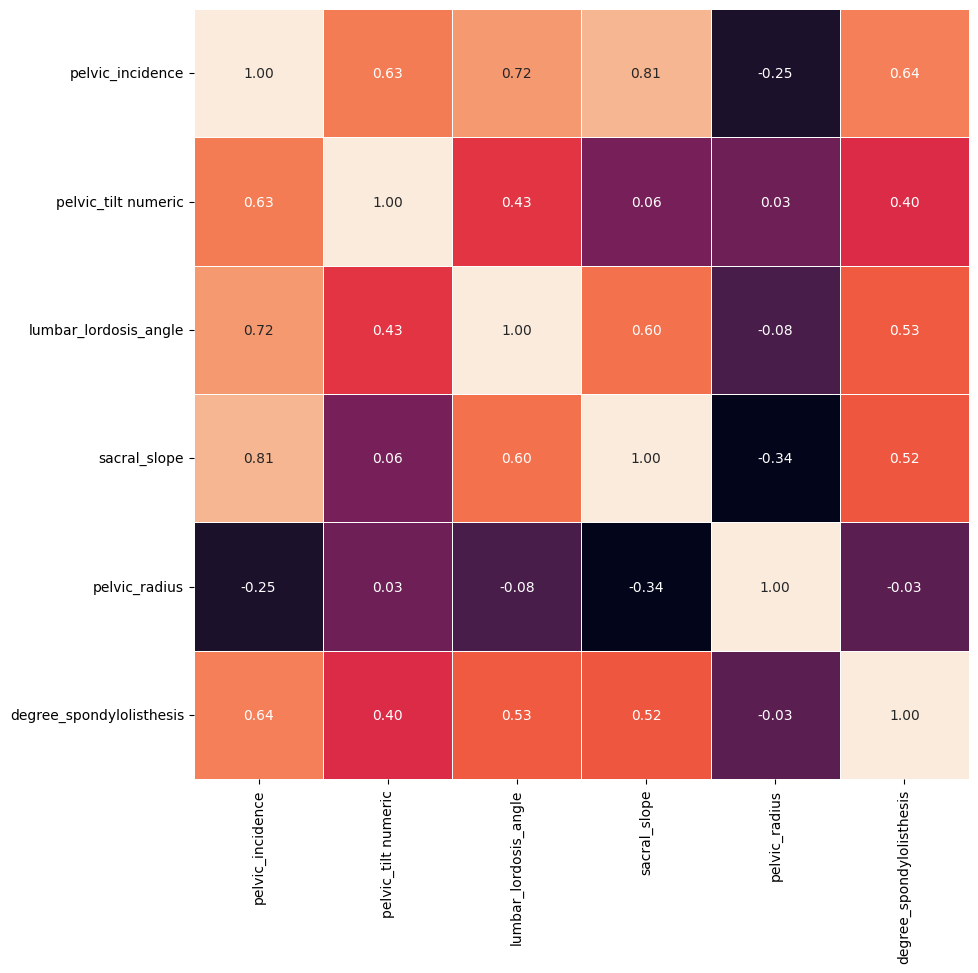

In [71]:
#correlation map
plt.figure(figsize=(10, 10))
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f')
plt.show()

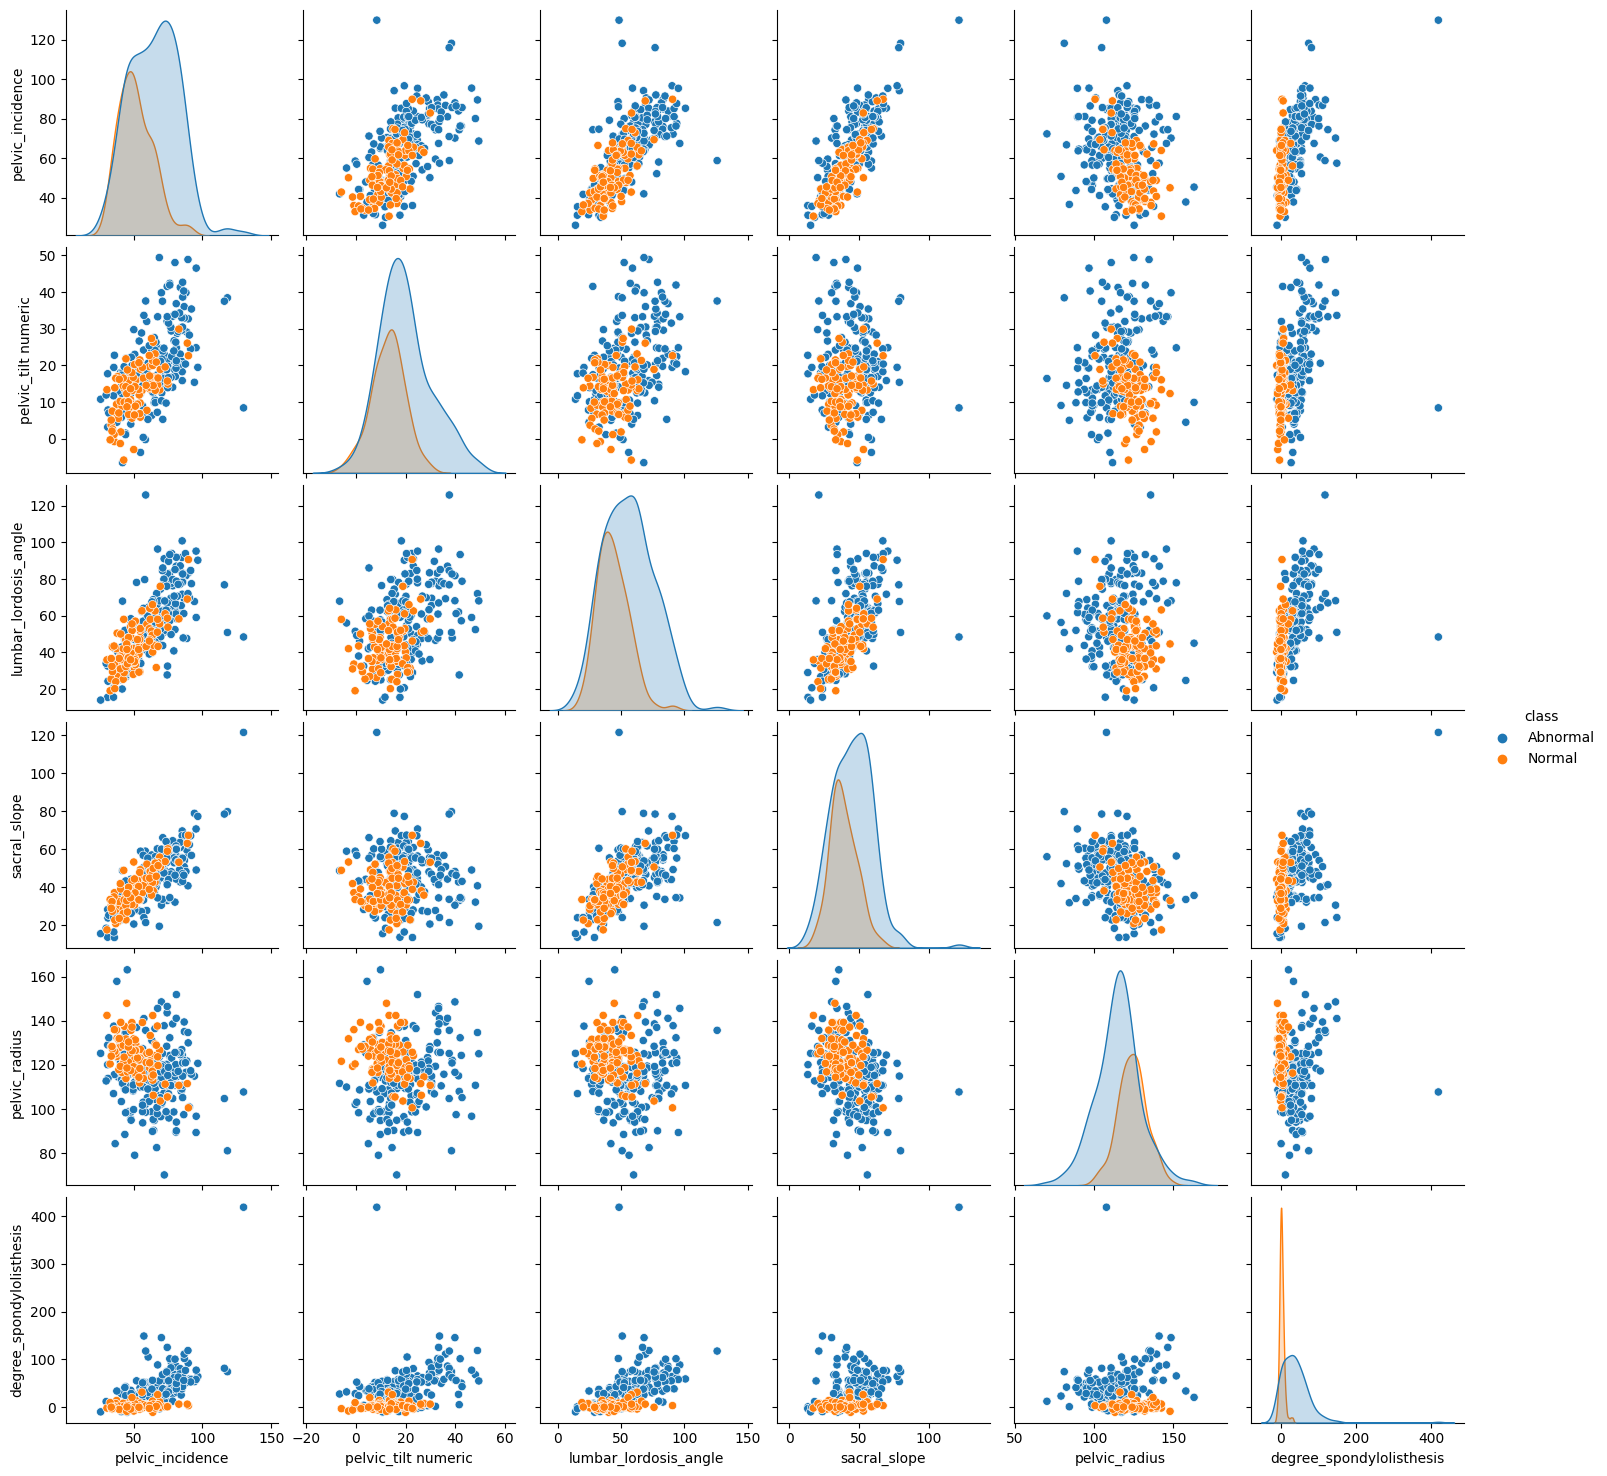

In [72]:
sns.pairplot(data, hue='class');

## Target variable encoding

In [73]:
data['class'] = data['class'].apply(lambda x: 1 if x=='Abnormal' else 0)

In [74]:
data.head()

,pelvic_incidence,pelvic_tilt numeric,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,1
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,1
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,1
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,1
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,1


## Train-test split

The `stratify` option allows you to create stratifications in which the distributions of the specified variable will be preserved. Very useful for class imbalances, ie. when some classes are much more common than others.

Try to answer why?

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['class'], axis=1), data['class'], test_size=0.20, random_state=42, stratify=data['class']
)

In [76]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((248, 6), (62, 6), (248,), (62,))

In [77]:
y_train.value_counts(normalize=True)

1    0.677419
0    0.322581
Name: class, dtype: float64

In [78]:
y_test.value_counts(normalize=True)

1    0.677419
0    0.322581
Name: class, dtype: float64

## Scaling
### Important! 
Learn on the train - apply on the test. Almost all preprocessing methods somehow use information from the sample, for example, when standardizing, the mean and variance are considered, which means that we do not want information from the deferred sample to leak into the training sample (data leak).

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Selection of parameters in different ways

In [80]:
from sklearn.model_selection import cross_val_score

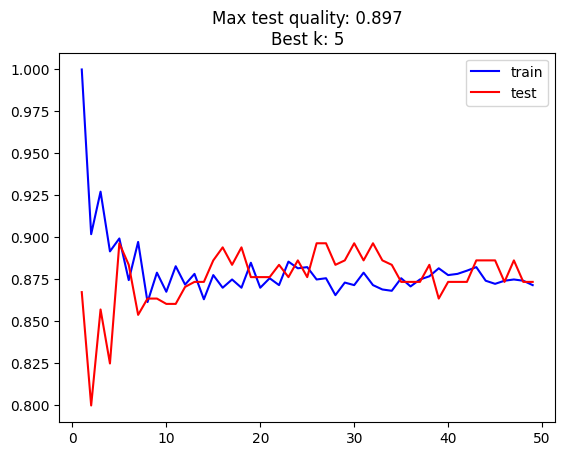

In [81]:
neighbors = range(1, 50)
f1_score_train = []
f1_score_test = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    f1_score_train.append(f1_score(knn.predict(X_train_scaled), y_train))
    f1_score_test.append(f1_score(knn.predict(X_test_scaled), y_test))
    
plt.plot(neighbors, f1_score_train, color='blue', label='train')
plt.plot(neighbors, f1_score_test, color='red', label='test')
plt.title("Max test quality: {:.3f}\nBest k: {}".format(max(f1_score_test), np.argmax(f1_score_test)+1))
plt.legend();

## GridSearchCV

In [82]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
        'n_neighbors': range(1, 50),
        'p': range(1, 4)
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1', verbose=1)
grid_search.fit(X_train_scaled, y_train)

print("Best CV score: {:.3f}, best CV k: {}".format(
    grid_search.best_score_, grid_search.best_estimator_.n_neighbors)
) 


test_predictions = grid_search.best_estimator_.predict(X_test_scaled)
print("Resulting test score: {:.3f}".format(f1_score(test_predictions, y_test)))

Fitting 5 folds for each of 147 candidates, totalling 735 fits
Best CV score: 0.885, best CV k: 33
Resulting test score: 0.886
CPU times: user 2.27 s, sys: 10.9 ms, total: 2.28 s
Wall time: 2.28 s


In [83]:
grid_search.best_estimator_.p

2

### Additional materials:
- https://www.ibm.com/topics/knn
- http://scikit-learn.org/stable/modules/neighbors.html
- https://www.cs.cornell.edu/courses/cs4780/2018fa/lectures/lecturenote02_kNN.html (dimensionality curse)
- https://www.kaggle.com/skalskip/iris-data-visualization-and-knn-classification